In [1]:
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mig
import numpy as np
import pyelsa as elsa
import preprocessing
import reconstruction
import utils
import aomip
import scipy.io as sio
from skimage import transform


pyelsa not build with CUDA projector support


# Homework 3: Preprocessing for computed tomography

0) data preparation

Data are read from the directory /Walnut2/Projections/tubeV1. Projections, dark field, and flat field images are read into the variables projs_name, dark_name and flat_name respectively. Although there 1201 projection images, eg, the variable projs_name should range from 'scan_000000.tif' to 'scan_001200.tif', but I am only using 50 projectios in this experiment set to speed up computation time and to save memory space. Eg, the num_projections variable is artificailly set to 50 instead of vecs.shape[0] which should be 1201. The data is originally captured in landscape mode, I follow the author's implementation to modify it into portrait mode using the trafo function.

In [4]:
## Prepare data
data_path = 'Walnut2/Projections/tubeV1'
projs_name = 'scan_{:06}.tif'
dark_name = 'di000000.tif'
flat_name = ['io000000.tif', 'io000001.tif']
vecs_name = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# load the numpy array describing the scan geometry from file
vecs = np.loadtxt(join(data_path, vecs_name))
# get the positions we need; there are in fact 1201, but the last and first one come from the same angle
vecs       = vecs[range(0,1200, 1)]
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision
projs_idx  = range(1200,0, -1)

num_projections = 50 #vecs.shape[0]

# create the numpy array which will receive projection data from tiff files
projs = np.zeros((num_projections, projs_rows, projs_cols), dtype=np.float32)

# Changing orientation from landscape to portrait mode
trafo = lambda image : np.transpose(np.flipud(image))

# load flat-field and dark-fields
# there are two flat-field images (taken before and after acquisition), we simply average them
dark = trafo(plt.imread(join(data_path, dark_name)))
flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)

# Combine avereate of the flat field image
for i, fn in enumerate(flat_name):
    flat[i] = trafo(plt.imread(join(data_path, fn)))
flat =  np.mean(flat,axis=0)

# load projection data
for i in range(num_projections):
    projs[i] = trafo(plt.imread(join(data_path, projs_name.format(projs_idx[i]))))

i) Flat-field correction

Formula (1) in [1] is used here. First, dark field images are substracted from all projection images (50 in this case), the n divided by the difference between the dark field and flat field image. As there are 2 flat field image given, I took the average of both images in this instace. The size of projections data is (num_projections, rows, colums) which is (50,972,768) which both light field and dark field images are (972,768), hence, numpy will apply broadcasting to each specific projection image in projs.

I plotted the image for projection 0 before flat field correction. Using eyeball scanning, the difference is not too pronounced, but on a closer look it appears some of the darker spot has appeared ligter after doing flat field corrections.

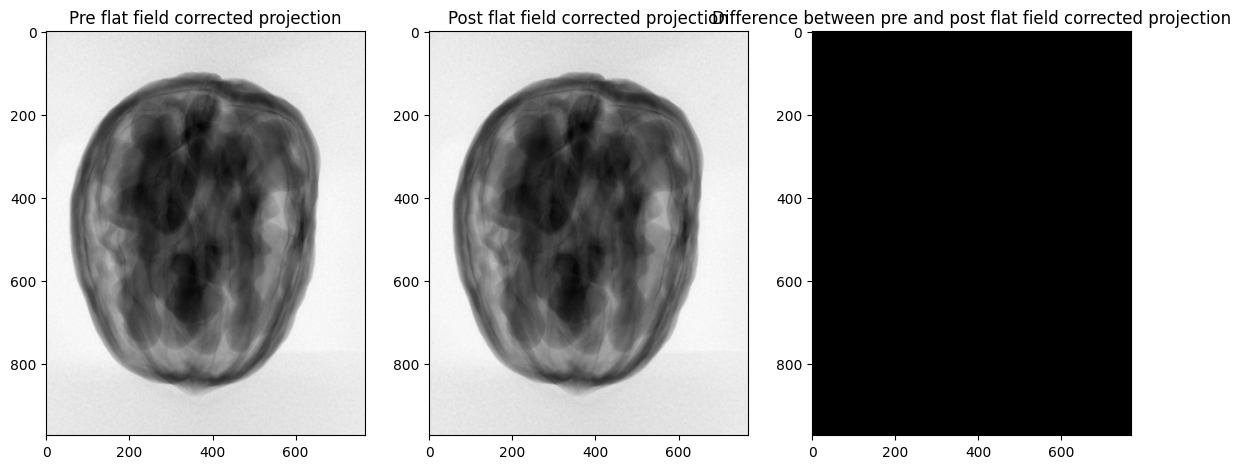

In [5]:
flatfield_corrected_projs=preprocessing.flatfield_correction(projs,dark,flat)
plt.figure(figsize=(14,6))
plt.subplot(1,3,1, title='Pre flat field corrected projection'); plt.imshow(projs[0],cmap='gray')
plt.subplot(1,3,2, title='Post flat field corrected projection'); plt.imshow(flatfield_corrected_projs[0],cmap='gray')
plt.subplot(1,3,3, title='Difference between pre and post flat field corrected projection')
plt.imshow(projs[0]-flatfield_corrected_projs[0],cmap='gray')


ii) Transmission to Absorption conversion

First, the initial intensity I0 is estimated by taking the mean of the top and bottom 25 pixels. Then, the absorption for each specific projetions is computed using the negative log transform, according to the Beer–Lambert law, using formula (3) in [1].


In [6]:
# Computation
I0=preprocessing.get_I0(num_projections,flatfield_corrected_projs,25)
absorption_image= preprocessing.get_absorption_image(num_projections,projs_rows,projs_cols,flatfield_corrected_projs,I0)

Illustration of the rate of absorption of projections 10 and 15. I have also plotted a bar to show the minimum and maximum absorption rate for these 2 projetions. This allow the reader to see the contrast between this section and the following section when the signal is cleaned.

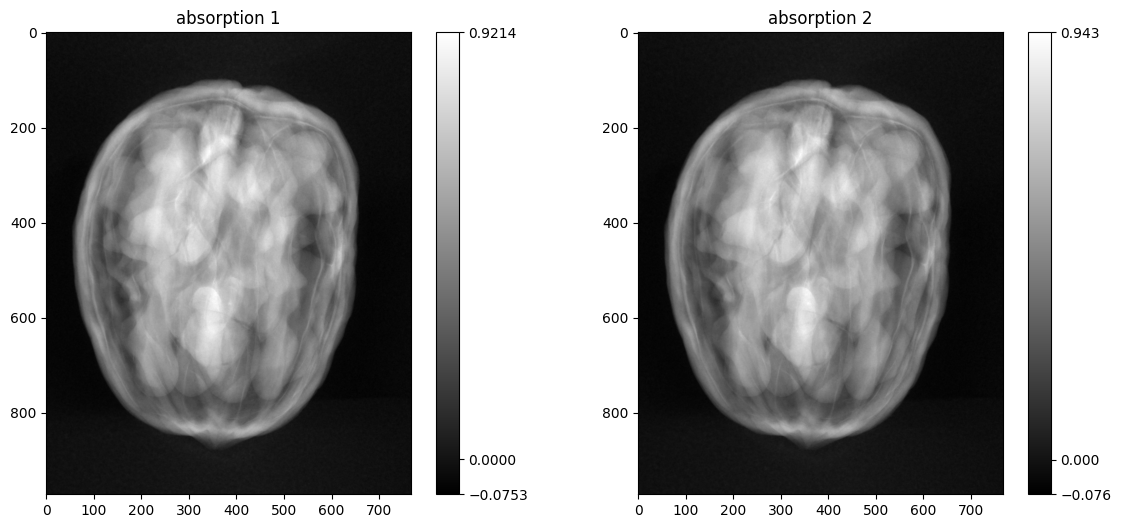

In [7]:
I1=absorption_image[10]
I2=absorption_image[15]
I1_min=np.min(I1)
I1_max=np.max(I1)
I2_min=np.min(I2)
I2_max=np.max(I2)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1, title='absorption 1') 
ax1=plt.imshow(I1, vmin=I1_min, vmax=I1_max,cmap='gray')
plt.subplot(1,2,2, title='absorption 2')
ax2=plt.imshow(I2,cmap='gray')
cbar=plt.colorbar(ax1)
cbar.set_ticks([I1_min, 0, I1_max])
cbar2=plt.colorbar(ax2)
cbar2.set_ticks([I2_min, 0, I2_max])
plt.show()

iii) Cleaning the signal

I employ the method in [1] where in the absorption image, everything below 0 is set to zero. The method is as follows:
look at the 2D array value for each absorption image from ii) then negative values in each of the (972x768) grid are set to 0.

In [8]:
# Computation, truncation of negative absorption rate
cleaned_signal = preprocessing.signal_cleaning(num_projections,projs_rows,projs_cols,absorption_image)

Illustration is the same as part ii) using projection 10 and 15. Here the min values become 0 instead of -0.0753 and -0.076 respectively.

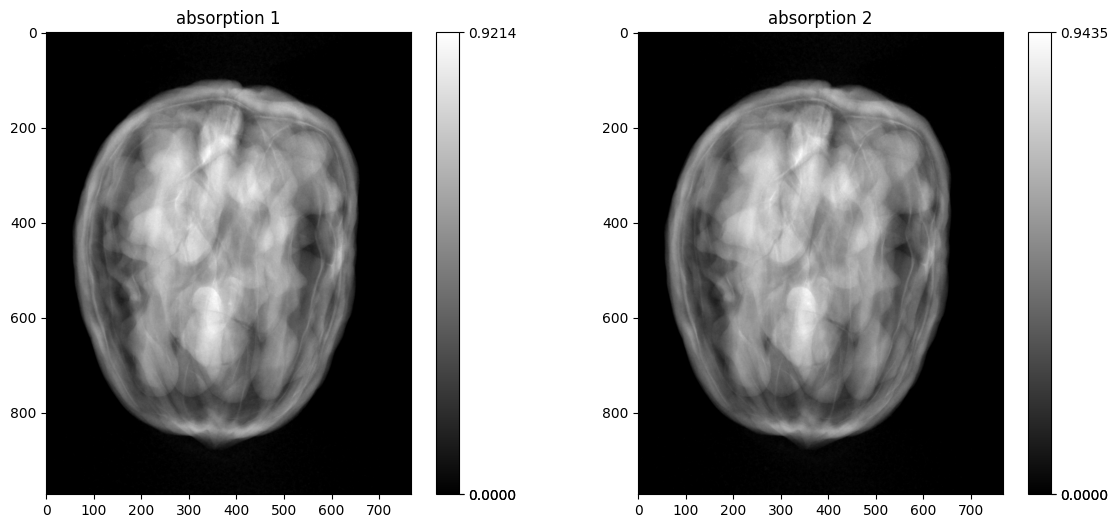

In [9]:
#Illustration of projection 10 and 200 after cleaning the signal
I1=cleaned_signal[10]
I2=cleaned_signal[15]
I1_min=np.min(I1)
I1_max=np.max(I1)
I2_min=np.min(I2)
I2_max=np.max(I2)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1, title='absorption 1') 
ax1=plt.imshow(I1, vmin=I1_min, vmax=I1_max,cmap='gray')
plt.subplot(1,2,2, title='absorption 2')
ax2=plt.imshow(I2,cmap='gray')
cbar=plt.colorbar(ax1)
cbar.set_ticks([I1_min, 0, I1_max])
cbar2=plt.colorbar(ax2)
cbar2.set_ticks([I2_min, 0, I2_max])
plt.show()

iv) Binning

First the binning factor is checked to ensure that it is of power of 2. Then, after determining the dimension of the input array (either 1D or 2D), it first calculates the size of the new dimension and initialize a zero vector for it. Then, it takes the mean of each block where the clock size is the bin factor.

In [10]:
new_projs_rows = (cleaned_signal[0].shape[0] // 2)
new_projs_cols = (cleaned_signal[0].shape[1] // 2)
bin_factor = 2
binned_projections = preprocessing.containerised_projections(num_projections,new_projs_rows,new_projs_cols,cleaned_signal,4,bin_factor)


As shown in the printed shape of the projection image and also the x and y axis of the right image, after binning is employed, the dimension is reduced by half.

Original shape: (972, 768)
Shape after binning by factor 2 : (486, 384)


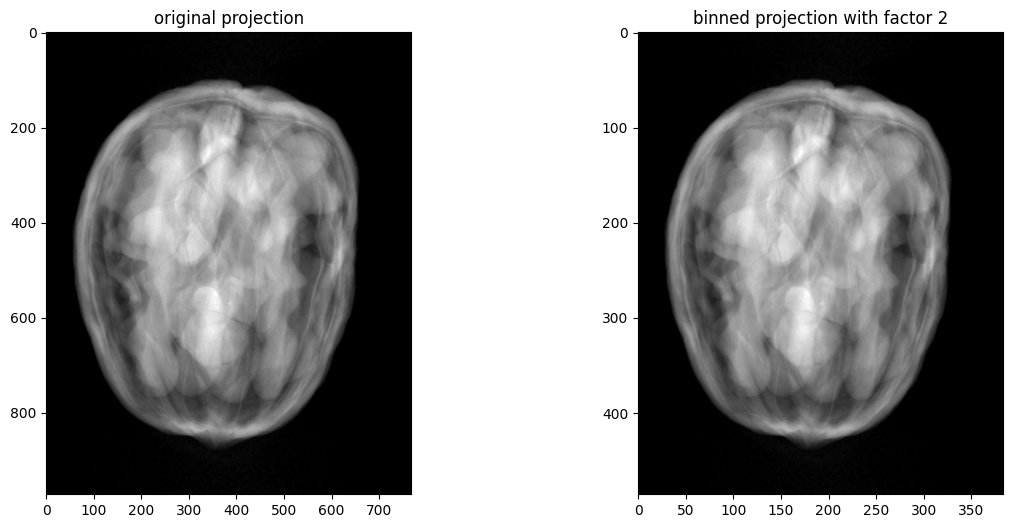

In [11]:
plt.figure(figsize=(14,6))
print("Original shape: {}"\
      .format(I1.shape))
print("Shape after binning by factor 2 : {}"\
      .format(binned_projections[10].shape))
plt.subplot(1,2,1, title='original projection') 
plt.imshow(I1, vmin=I1_min, vmax=I1_max,cmap='gray')
plt.subplot(1,2,2, title='binned projection with factor 2')
plt.imshow(binned_projections[10],cmap='gray')

v) Center of rotation correction

np roll method is used to handle the correction. It is employed on the last axis of the projection image by setting the parameter axis=-1. In the function correct_center_of_rotation in preprocessing.py, the parameter roll_pixels controls the shift. Positive value shift the image to the right and negative values shift it to the left.

In [12]:
rolled_pixel = 50
rolled_projections = preprocessing.correct_center_of_rotation(num_projections,new_projs_rows,new_projs_cols,binned_projections,rolled_pixel)

Here, a high roll value, 50 is used the contrast between unshift and shifted projection is more striking.

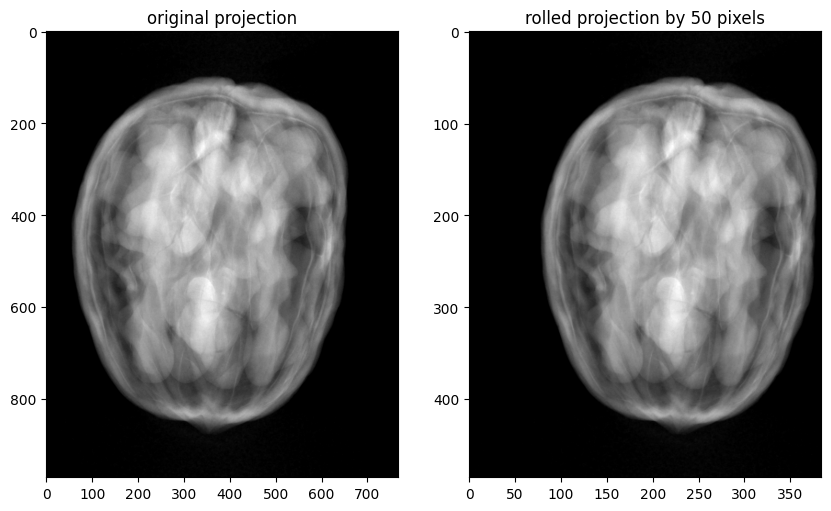

In [13]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1, title='original projection') 
plt.imshow(I1,cmap='gray')
plt.subplot(1,2,2, title='rolled projection by 50 pixels')
plt.imshow(rolled_projections[10],cmap='gray')

vi) Padding

0 padding is added on all sides of projection. First, the function creates a new array with the desired padding size and then copy the original image into the padded array.

In [14]:
padded_projections = preprocessing.apply_padding(num_projections,new_projs_rows,new_projs_cols,rolled_projections,50)

As can be seen from the printout and the right plot below, the horizontal and vertical direction are padded which increase the size by 100 across both direction.

Original shape from v): (486, 384)
Shape after padded by 50 pixels : (586, 484)


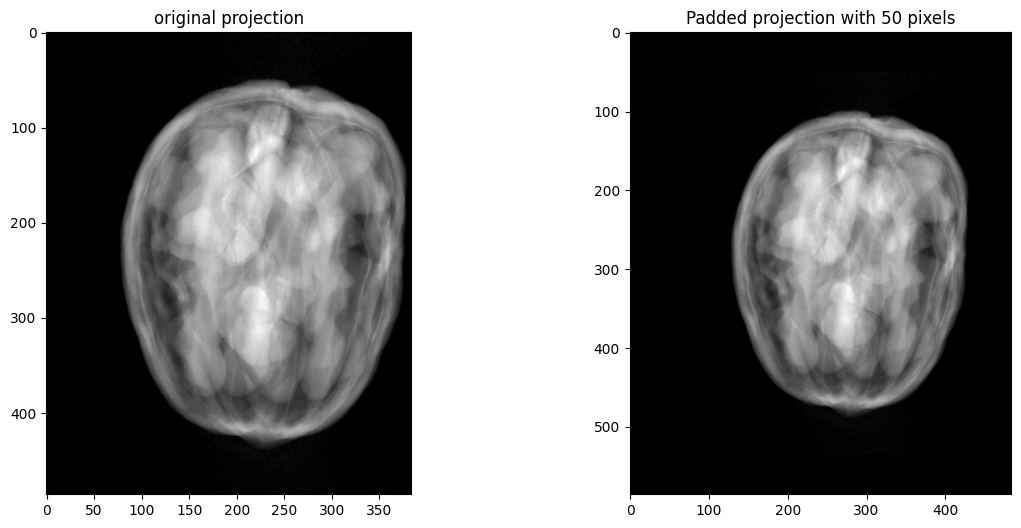

In [15]:
print("Original shape from v): {}"\
      .format(rolled_projections[10].shape))
print("Shape after padded by 50 pixels : {}"\
      .format(padded_projections[10].shape))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1, title='original projection') 
plt.imshow(rolled_projections[10],cmap='gray')
plt.subplot(1,2,2, title='Padded projection with 50 pixels')
plt.imshow(padded_projections[10],cmap='gray')

# Homework 4: Analytical Reconstruction

the sinogrram data are read from Data82.mat and the reconstructed ground truth data of the cross section of a walnut is read from GroundTruthReconstruction.mat 

In [20]:
## Prepare fan beam data
data = sio.loadmat('Data82.mat')
fan_sinogram = np.array(data['m'])

## ground truth data
ground_truth_mat = sio.loadmat('GroundTruthReconstruction.mat')
var_names = ground_truth_mat.keys()
ground_truth = np.array(ground_truth_mat['FBP1200'])


First, in the filtered back projection algorithm employed in reconstruction.py _get_fbp. 3 different filters are implemented which are the Ram-Lak, Sheep-Logan and Cosine filters. Additionally, I also implemented one without filter to show the difference between filtered and unfiltered backprojection. First, data is transformed into the fourier domain via the fast fourier transform algorithm in numpy, then it is multiplied by the filter and the transformed back using the inverse fourier transform. This operation is linear and is computed with simple matrix multiplication. Finally, as this dataset contains 120 projections, the angle to reconstrcut is 120 degrees as the fbp algorithm in the integral over each of the defined angle. In these 120 degrees, there are 360 points in between to interpolate the reconstructed data points. Details of this implementation is from chapter 6, section 6.3 of the book Computed Tomography: Algorithms, Insight, and Just Enough Theory. 

In the illustration below, the reconstruction results from the 3 filter (ram-lak, shepp-logan, cosine) and without filter is obtained and compared to the ground truth data. As seen below, there are not much difference between the reconstruction results from the 3 filters. However, the contrast is big when the sinogram is recontructed without using any filter.

MSE error between resized ground truth and reconstrution using ramp filter: 0.03747100334303665
MSE error between resized ground truth and reconstrution using sheep-logan filter: 0.03747100334303665
MSE error between resized ground truth and reconstrution using cosine filter: 0.03747100334303665
MSE error between resized ground truth and reconstrution without filter: 0.19701886801504842


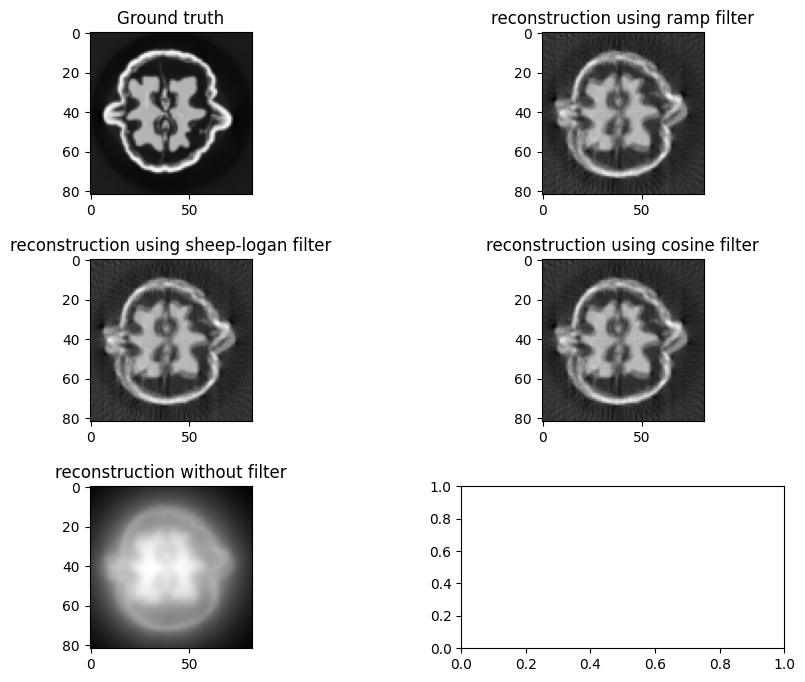

In [6]:
# reconI0 = padded_projections[10]
# arc = 360
# nangles = 120
# theta = np.linspace(0, arc, nangles)
# sinogram = aomip.radon(reconI0, [82], theta, 66, 190)

reconstruct_ramp = reconstruction._get_fbp(fan_sinogram,np.linspace(0, 360, 120),filter_name="ramp")
reconstruct_sheep_logan = reconstruction._get_fbp(fan_sinogram,np.linspace(0, 360, 120),filter_name="shepp-logan")
reconstruct_cosine = reconstruction._get_fbp(fan_sinogram,np.linspace(0, 360, 120),filter_name="cosine")
rconstruct_none = reconstruction._get_fbp(fan_sinogram,np.linspace(0, 360, 120),filter_name="none")

# resized the ground truth data to be the same as reconstructed image, to make error calculation and comparison easier
resized_gt = transform.resize(ground_truth,reconstruct_ramp.shape)

print("MSE error between resized ground truth and reconstrution using ramp filter: {}"\
      .format(reconstruction.mse(resized_gt, reconstruct_ramp)))
print("MSE error between resized ground truth and reconstrution using sheep-logan filter: {}"\
      .format(reconstruction.mse(resized_gt, reconstruct_sheep_logan)))
print("MSE error between resized ground truth and reconstrution using cosine filter: {}"\
      .format(reconstruction.mse(resized_gt, reconstruct_cosine)))
print("MSE error between resized ground truth and reconstrution without filter: {}"\
      .format(reconstruction.mse(resized_gt, rconstruct_none)))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

axs[0, 0].imshow(resized_gt, cmap='gray')
axs[0, 0].set_title('Ground truth')
axs[0, 1].imshow(reconstruct_ramp, cmap='gray')
axs[0, 1].set_title('reconstruction using ramp filter')
axs[1, 0].imshow(reconstruct_sheep_logan, cmap='gray')
axs[1, 0].set_title('reconstruction using sheep-logan filter')
axs[1, 1].imshow(reconstruct_cosine, cmap='gray')
axs[1, 1].set_title('reconstruction using cosine filter')
axs[2, 0].imshow(rconstruct_none, cmap='gray')
axs[2, 0].set_title('reconstruction without filter')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

utils.save_array_as_image(reconstruct_ramp,"reconstruct_ramp_filter.png","reconstruction")
utils.save_array_as_image(reconstruct_sheep_logan,"reconstruct_sheep_logan.png","reconstruction")
utils.save_array_as_image(reconstruct_cosine,"reconstruct_cosine.png","reconstruction")
utils.save_array_as_image(rconstruct_none,"rconstruct_none.png","reconstruction")

# Reference 
1. https://gitlab.lrz.de/groups/IP/teaching/applied-optimization-methods-for-inverse-problems/-/wikis/uploads/d51257cd52c9152f827d41fd631d2ed7/homework01.pdf